In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from es import *

import RL_formulation as rl
import agent_arch as arch

In [2]:
def apply_solution(solution_not_norm, show=False):

    solution = solution_not_norm / 1 # np.linalg.norm(solution_not_norm)

    num_of_steps = 24
    env = rl.Environment()

    agent = arch.Agent()

    agent.updateParams(solution)

    [[states, actions, total_reward],
     [desired_total_Production_in_dinamics,
      total_Production_in_dinamics,
      run_out_of_elecs]]                 = rl.generate_episode(env, agent, num_of_steps, simple_action=False, show=show)
                                           

    num_of_switches = []
    # total_run_out_for_elecs = []
    for j in range(env.num_of_elecs):
        # total_run_out_for_elecs.append(env.Plant[j].total_run_out)
        num_of_switches.append(env.Plant[j].switch_num)

    Production_Error_in_dinamics = np.array(desired_total_Production_in_dinamics) - np.array(total_Production_in_dinamics)

    return [Production_Error_in_dinamics, run_out_of_elecs,
            np.array(total_Production_in_dinamics), np.array(desired_total_Production_in_dinamics), num_of_switches]


In [3]:
def get_num_params():
    agent = arch.Agent()
    param_count = 0
    for param in agent.model.parameters():
      #print(param.data.shape)
      param_count += np.product(param.data.shape)

    del agent

    return param_count


In [4]:
import pickle

In [5]:

def init_train_attributes(from_file = True): # deserialization

    folder = 'serialised_data_CMAES_MarkovDelta_t'

    param_count = get_num_params()

    sigma_init = 0.5  # 0.1

    popsize = 100

    es = CMAES(num_params=param_count, sigma_init=sigma_init, popsize=popsize)

    if from_file:
        file_es = open(folder + '/evalution_strategy.pkl', 'rb')
        old_es = pickle.load(file_es)
        file_es.close()

        es.es = old_es

        del old_es

        #es.es.sigma = 0.6

        file_params = open(folder + '/best_params.pkl', 'rb')

        file_log = open(folder + '/best_scores_in_generations_log.pkl', 'rb')
        file_dict_score_solution = open(folder + '/dict_score_solution.pkl', 'rb')


        best_params = pickle.load(file_params)

        best_scores_in_generations_log = pickle.load(file_log)
        max_min_score_solution = pickle.load(file_dict_score_solution)


        file_params.close()

        file_log.close()
        file_dict_score_solution.close()

        best_score_solution = max_min_score_solution[0]
        worst_score_solution = max_min_score_solution[1]

    else:
        #es.es.x0 = copy.deepcopy(best_params)

        best_params = [0]*param_count

        best_scores_in_generations_log = []

        best_score_solution = [-np.inf, []] # [best_score, best_solution]
        worst_score_solution = [0, []]

    return [es, best_params, best_scores_in_generations_log, best_score_solution, worst_score_solution]



In [6]:

def solution_analysis(solution, n_test_episodes = 3):

    reward_account = rl.Reward()

    score = 0

    for _ in range(n_test_episodes):

        [Production_Error_in_dinamics, total_run_out_for_elecs,
        total_Production_in_dinamics,
        desired_total_Production_in_dinamics,
        num_of_switches]                                            = apply_solution(solution)

        [neg_J, MSE, mean_error, asymetric_error,
        max_total_run_out,
        run_out_deviation_RMSE] = reward_account.account(Production_Error_in_dinamics, total_run_out_for_elecs)

        score += neg_J

    return score / n_test_episodes



In [7]:
from joblib import Parallel, delayed


In [8]:

def train_for_some_generations(generations_num, train_attributes, parallel=True, n_jobs=-1):

    [es, best_params, best_scores_in_generations_log, best_score_solution, worst_score_solution] = train_attributes

    for i in range(generations_num):

        solutions = es.ask()

        if parallel:
            reward_list = Parallel(n_jobs=n_jobs)(delayed(solution_analysis)(solution) for solution in solutions)

        else:
            reward_list = []

            solut_number = 0
            for solution in solutions:  # можно параллельно

                score = solution_analysis(solution)

                reward_list.append(score)

                print(str(solut_number) + ' solution is aplied, score = ' + str(score) + '  min-max = ' + str(
                    min(solution)) + ' -- ' + str(max(solution)))

                if score > best_score_solution[0]:
                    best_score_solution[0] = copy.deepcopy(score)
                    best_score_solution[1] = copy.deepcopy(solution)

                if score < worst_score_solution[0]:
                    worst_score_solution[0] = copy.deepcopy(score)
                    worst_score_solution[1] = copy.deepcopy(solution)

                solut_number += 1

        es.tell(reward_list)

        es_solution = es.result()

#         model_params = es_solution[0] # best historical solution

        best_reward = es_solution[1] # best reward
        curr_best_reward = es_solution[2] # best of the current batch

        curr_best_reward_my_for_validation = max(reward_list)

        print(str(i) + "  ==>>", end=' ')
        print(curr_best_reward_my_for_validation, end=' === ')
        print(curr_best_reward, end=' === ')
        print(best_reward, end=' === ')
        print(es.rms_stdev())


        best_scores_in_generations_log.append(curr_best_reward_my_for_validation)


    return [es.result(), es.current_param()] # best historical solution



In [9]:

def serialization(es, best_solution, best_scores_in_generations_log, best_score_solution, worst_score_solution, folder='serialised_data_CMAES_MarkovDelta_t'):

    file_es = open(folder+'/evalution_strategy.pkl', 'wb')

    pickle.dump(es.es, file_es)

    file_es.close()

    file_params = open(folder+'/best_params.pkl', 'wb')

    file_log = open(folder+'/best_scores_in_generations_log.pkl', 'wb')
    file_dict_score_solution = open(folder+'/dict_score_solution.pkl', 'wb')

    pickle.dump(best_solution, file_params)

    pickle.dump(best_scores_in_generations_log, file_log)

    max_min_score_solution = [best_score_solution, worst_score_solution]
    pickle.dump(max_min_score_solution, file_dict_score_solution)

    file_params.close()

    file_log.close()
    file_dict_score_solution.close()


In [10]:
from_file = True
parallel = True
n_jobs = -1

generations_num = 2

In [11]:
[es, best_params, 
 best_scores_in_generations_log, 
 best_score_solution, 
 worst_score_solution]                      = init_train_attributes(from_file=from_file)

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 8060 (seed=585048, Wed Apr 20 10:23:03 2022)


In [12]:


%%time

print('start training')

train_Report = train_for_some_generations(generations_num,
                                          [es, best_params, best_scores_in_generations_log, 
                                           best_score_solution, worst_score_solution],
                                          parallel=parallel,
                                          n_jobs=n_jobs)

print('end training')
print()

start training
0  ==>> -19.943489834579772 === -19.428191346826832 === -19.428191346826832 === 0.5838991441040451
1  ==>> -19.182166045210675 === -18.66796022363165 === -18.66796022363165 === 0.5838933881378284
end training

CPU times: user 9min 8s, sys: 11.6 s, total: 9min 20s
Wall time: 5min 31s


In [13]:
curr_solution = train_Report[1]

best_solution = train_Report[0][0]

print('max of curr_solution = ' + str(max(curr_solution)))
print('min of curr_solution = ' + str(min(curr_solution)))
print()

print('length of best_scores_in_generations_log = ' + str(len(best_scores_in_generations_log)))

best_score_solution = [train_Report[0][1], best_solution]

print('best_score_solution = ')
print(best_score_solution)
print()

print('curr_solution = ')
print(curr_solution)
print()

max of curr_solution = 39.432742837992734
min of curr_solution = -24.9742469868437

length of best_scores_in_generations_log = 4802
best_score_solution = 
[-18.66796022363165, array([ -4.22983916, -22.99989194,   2.77022428, ...,   7.65990876,
         3.66746353,  -8.43995123])]

curr_solution = 
[ -3.91580266 -22.50665808   1.96614309 ...   7.65254697   3.35198093
  -8.44659101]



In [23]:
# simulation and score account
[Production_Error_in_dinamics, total_run_out_for_elecs,
 total_Production_in_dinamics, desired_total_Production_in_dinamics, num_of_switches] = apply_solution(
 curr_solution)

reward_account = rl.Reward()

[neg_J, MSE, mean_error, asymetric_error,
 max_total_run_out,
 run_out_deviation_RMSE] = reward_account.account(Production_Error_in_dinamics, total_run_out_for_elecs)

del reward_account

print('=========================== SCORE of the current soluion')
print('neg_J = ' + str(neg_J))
print('RMSE = ' + str(MSE ** 0.5))
print('mean_error = ' + str(mean_error))
print('asymetric_error = ' + str(asymetric_error))
print('max_total_run_out = ' + str(max_total_run_out))
# print(min_max_tot_run_out)
print('run_out_deviation_RMSE = ' + str(run_out_deviation_RMSE))
print("switc num = ", end=' ')
print(num_of_switches)
print(sum(num_of_switches))
print(max(total_run_out_for_elecs) / sum(total_run_out_for_elecs))
print()


# [Production_Error_in_dinamics, total_run_out_for_elecs,
#  total_Production_in_dinamics, desired_total_Production_in_dinamics, num_of_switches] = apply_solution(
#  best_solution)

# reward_account = rl.Reward()

# [neg_J, MSE, mean_error, asymetric_error,
#  max_total_run_out,
#  run_out_deviation_RMSE] = reward_account.account(Production_Error_in_dinamics, total_run_out_for_elecs)

# del reward_account

# print('=========================== SCORE of the best solution')
# print('neg_J = ' + str(neg_J))
# print('RMSE = ' + str(MSE ** 0.5))
# print('mean_error = ' + str(mean_error))
# print('asymetric_error = ' + str(asymetric_error))
# print('max_total_run_out = ' + str(max_total_run_out))
# # print(min_max_tot_run_out)
# print('run_out_deviation_RMSE = ' + str(run_out_deviation_RMSE))
# print("switc num = ", end=' ')
# print(num_of_switches)
# print(sum(num_of_switches))
# print(max(total_run_out_for_elecs) / sum(total_run_out_for_elecs))
# print()


=========================== SCORE of the current soluion
neg_J = -23.71398052379393
RMSE = 67.8077066356808
mean_error = -11.187645259941954
asymetric_error = 125.16371622877993
max_total_run_out = 39211.99999999175
run_out_deviation_RMSE = 12937.142665449288
switc num =  [1, 7, 1, 5, 2]
16
0.41321329928874934



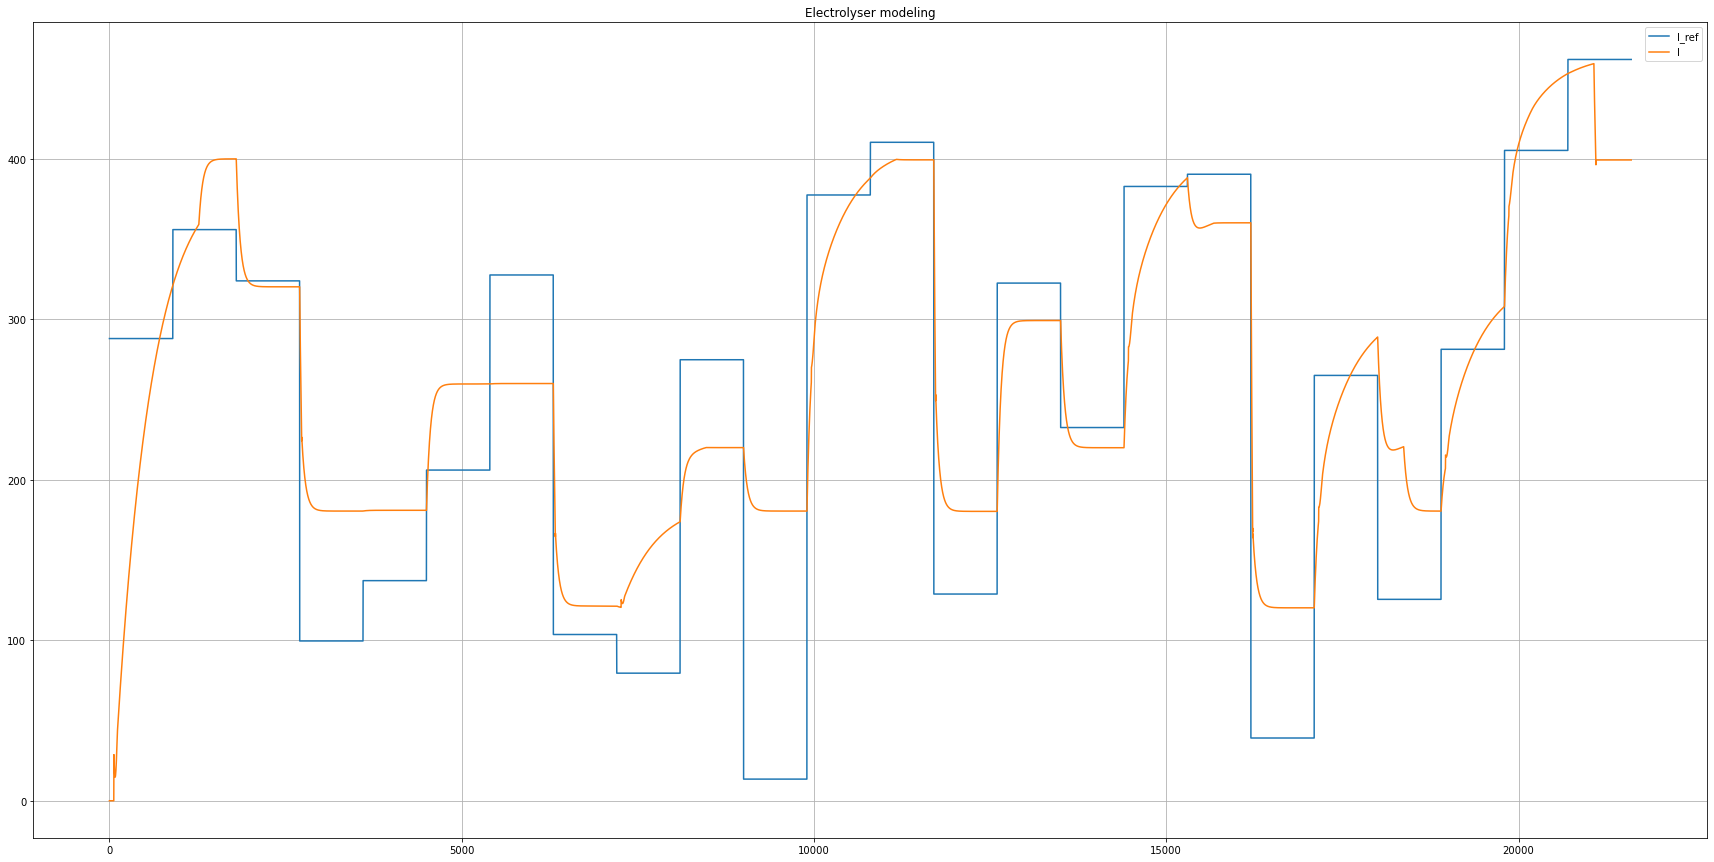

In [24]:
# plot PR and PR_ref
plt.figure(figsize=(30, 15))
plt.title("Electrolyser modeling")
plt.plot(desired_total_Production_in_dinamics, label='I_ref')
plt.plot(total_Production_in_dinamics, label='I')

plt.legend()
plt.grid(visible=True)
plt.show()

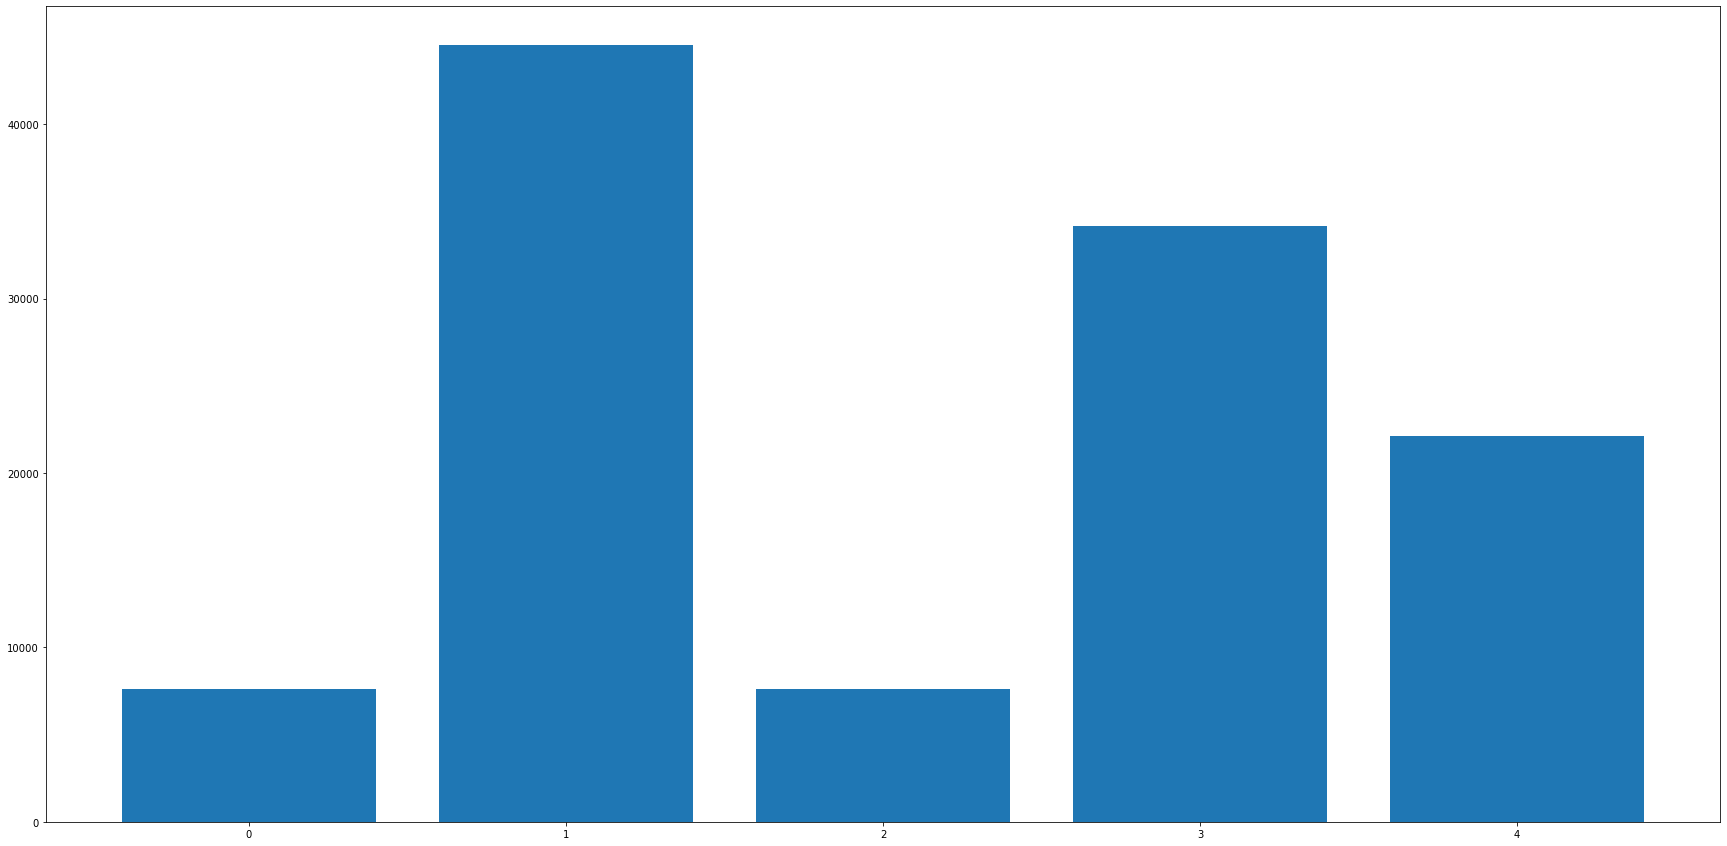

In [16]:
# plot hist
num_elecs = 5
names = list(range(num_elecs))
values = total_run_out_for_elecs

plt.figure(figsize=(30, 15))
plt.bar(names, values)
plt.show()

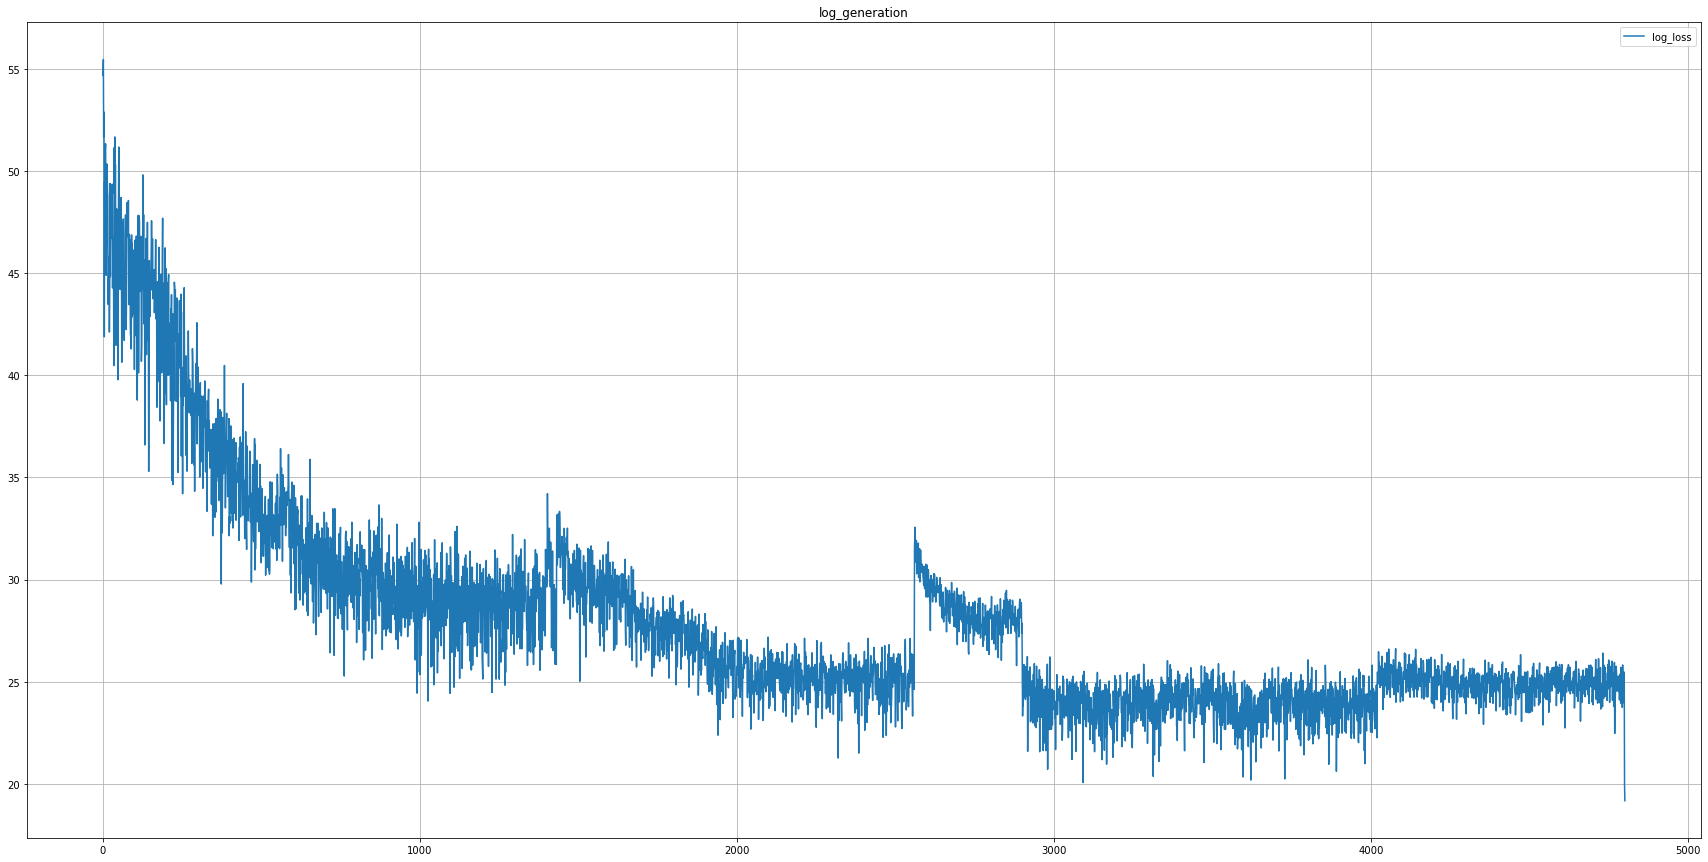

In [18]:
# plot neg_loss
plt.figure(figsize=(30, 15))
plt.title("log_generation")
plt.plot((-np.array(best_scores_in_generations_log)), label='log_loss')

plt.legend()
plt.grid(visible=True)
plt.show()
    

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 8060 (seed=298487, Sun Apr 17 13:35:19 2022)
start training
0  ==>> -25.020370308184308 === -19.785065791182582 === -19.785065791182582 === 0.5915972365600064
1  ==>> -23.276369541245554 === -19.785065791182582 === -19.785065791182582 === 0.5916063713025324
end training

max of curr_solution = 33.42697985855659
min of curr_solution = -20.694480906297283

length of best_scores_in_generations_log = 3102
best_score_solution = 
[-19.785065791182582, array([  0.28877798, -10.5323814 ,  -2.51204064, ...,  11.98690713,
        -1.40736513,  -0.90485727])]

curr_solution = 
[ -0.26331505 -10.86963077  -2.54646764 ...  11.92676557  -0.90625333
  -0.82778113]

=========================== SCORE of the current soluion
neg_J = -31.907609717526913
RMSE = 97.08152962278557
mean_error = 9.552521645091343
asymetric_error = 365.0081064615763
max_total_run_out = 34136.69999999416
run_out_deviation_RMSE = 10502.084153456803
switc num =  [1, 6, 1, 4, 2]
14

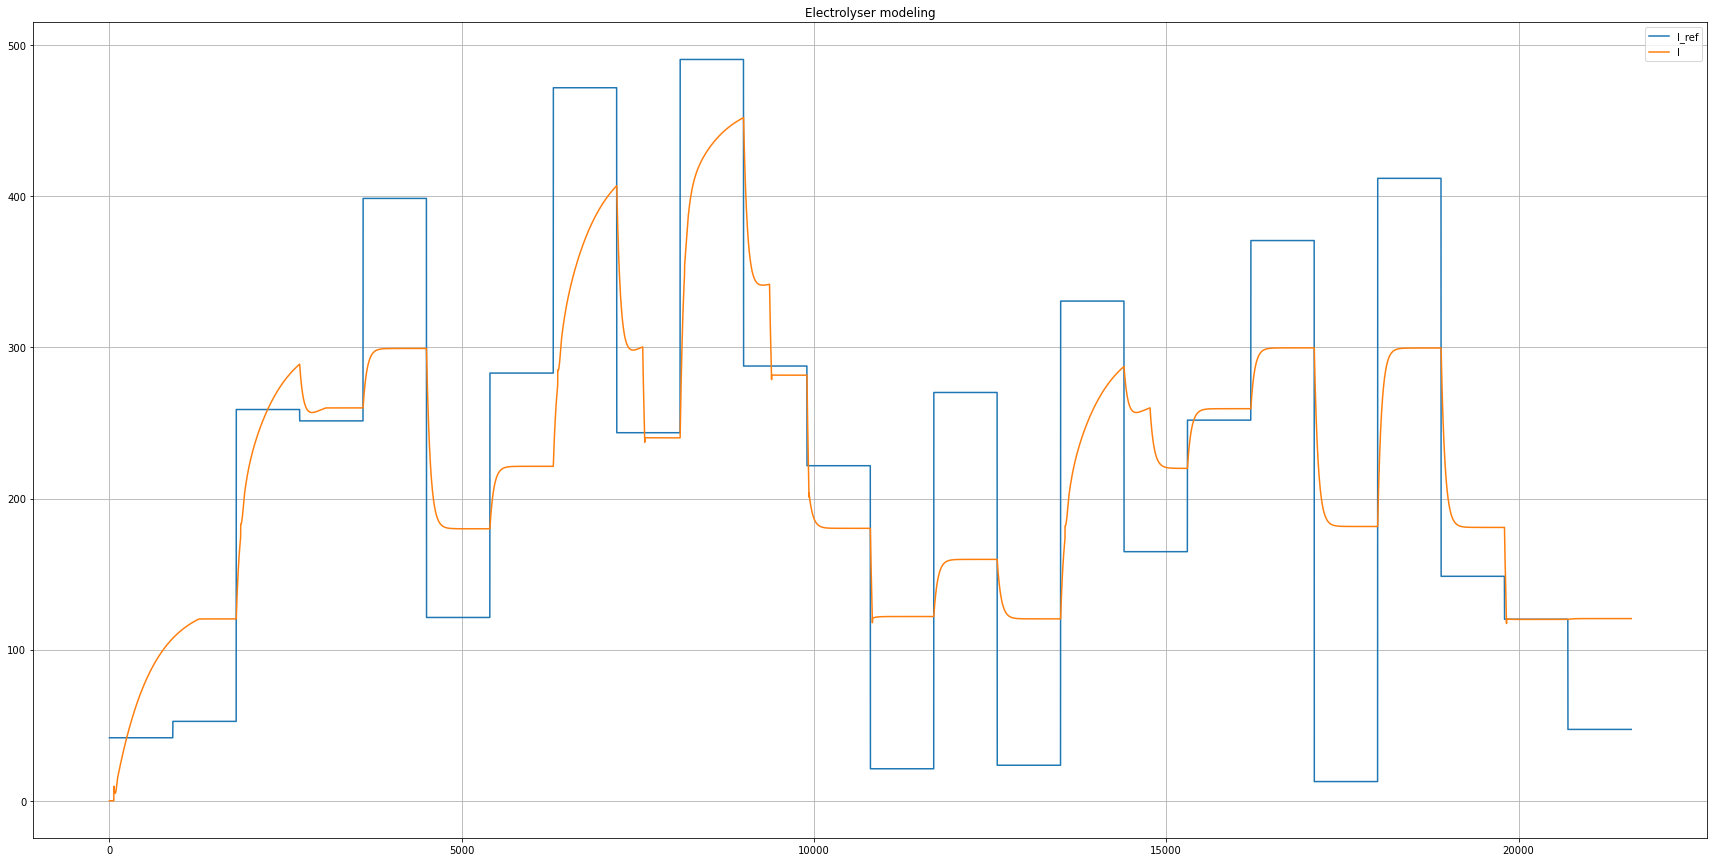

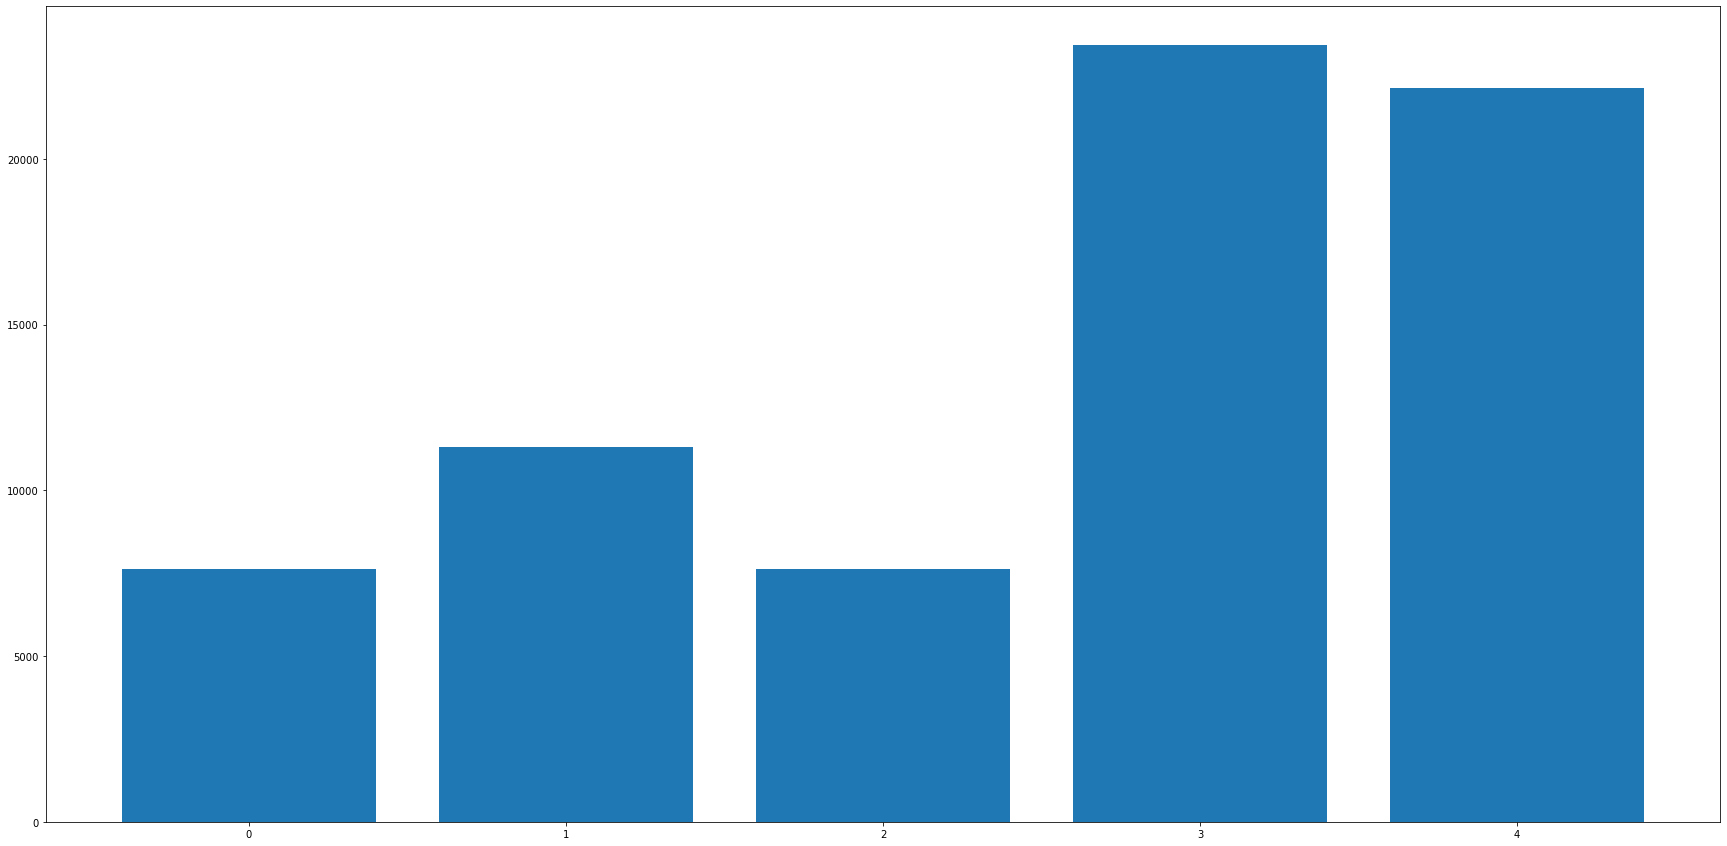

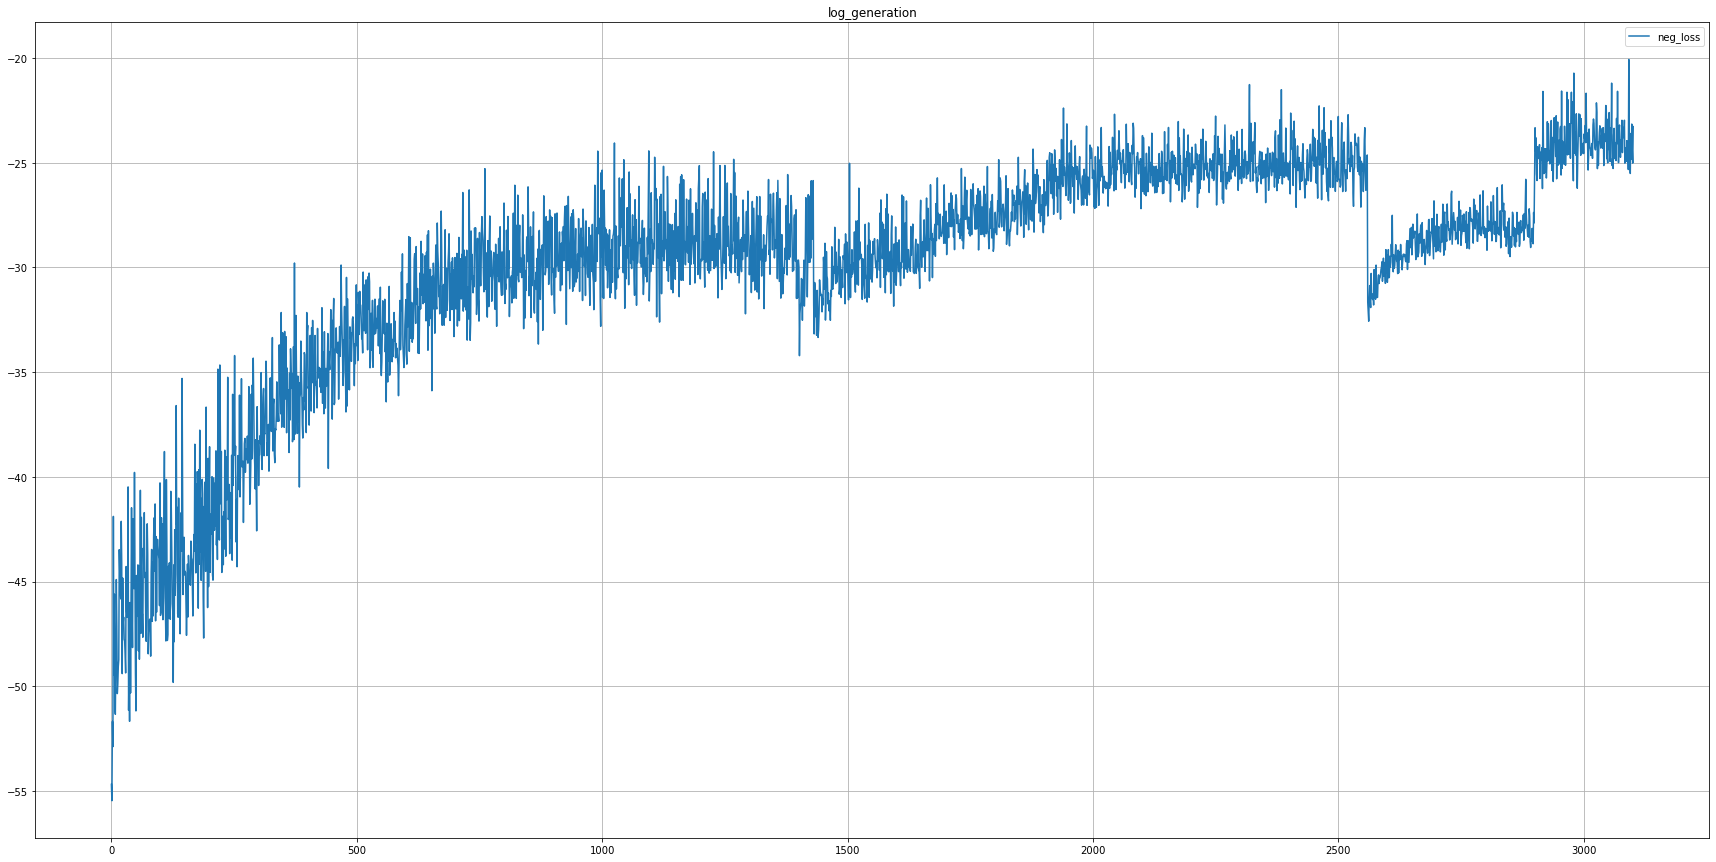

In [15]:
%%time


# serialization
serialization(es, best_solution, best_scores_in_generations_log, best_score_solution, worst_score_solution,
              folder='serialised_data_CMAES_MarkovDelta_t')
